<a href="https://colab.research.google.com/github/noraleilaa/458/blob/main/A_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiments A: EDA: For NLP projects, it is very important to do extensive EDA and do the preprocessing before defining models. These are the suggestions.

(a) Vocabulary Size: Tweak the vocabulary size, at least 3 levels.

(b) Editing the Vocabulary: Try unedited most frequent words, VS edit the list by deleting the most frequent words such as articles, ‘the’, ‘a’, etc.

(c) Output sequence length: Use the default VS set it to a fixed number

Experiments B: RNN: Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

Experiments C: LSTM: Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

Experiment D: 1D CNN

Bottomline: You need to  do at least 10 experiments or more.

Result:  Create a table with the accuracy and loss for train/test/validation & process time for all the models

Experiment A (EDA)

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


In [4]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare \
        --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)

W0219 23:57:49.489114 135172450152448 download_and_prepare.py:46] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.datasets.ag_news_subset.ag_news_subset_dataset_builder
2024-02-19 23:57:50.139388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 23:57:50.139467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 23:57:50.141559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 23:57:55.351414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [6]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [7]:
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [8]:
# review class balance
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [9]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")


In [10]:
%%time
max_tokens = None
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)

CPU times: user 3min 3s, sys: 11.8 s, total: 3min 15s
Wall time: 3min 41s


In [11]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = text_vectorization(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.
CPU times: user 14min 47s, sys: 8.12 s, total: 14min 55s
Wall time: 15min 22s


In [12]:
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

There are 95827 vocabulary words in the corpus.


In [13]:
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:50])

['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


#Vocab tweaking

In [14]:
import random
#vocab tweaked one level
'''vocab1 = np.array(text_vectorization.get_vocabulary(:500))
print(len(vocab1))'''

vocab_full = text_vectorization.get_vocabulary()
vocab1 = np.array(random.sample(vocab_full, 500))
print(len(vocab1))

500


In [15]:
#vocab tweaked second level
vocab2 = np.array(random.sample(vocab_full, 2000))
print(len(vocab2))

2000


In [16]:
#vocab tweaked third level
vocab3 = np.array(random.sample(vocab_full, 4000))
print(len(vocab3))

4000


#Frequency of words depending on edited list

In [17]:
vocab_filtered_1 = custom_stopwords(vocab1)

vocab_filtered_2 = custom_stopwords(vocab2)

vocab_filtered_3 = custom_stopwords(vocab3)

vocab_filtered = custom_stopwords(vocab)

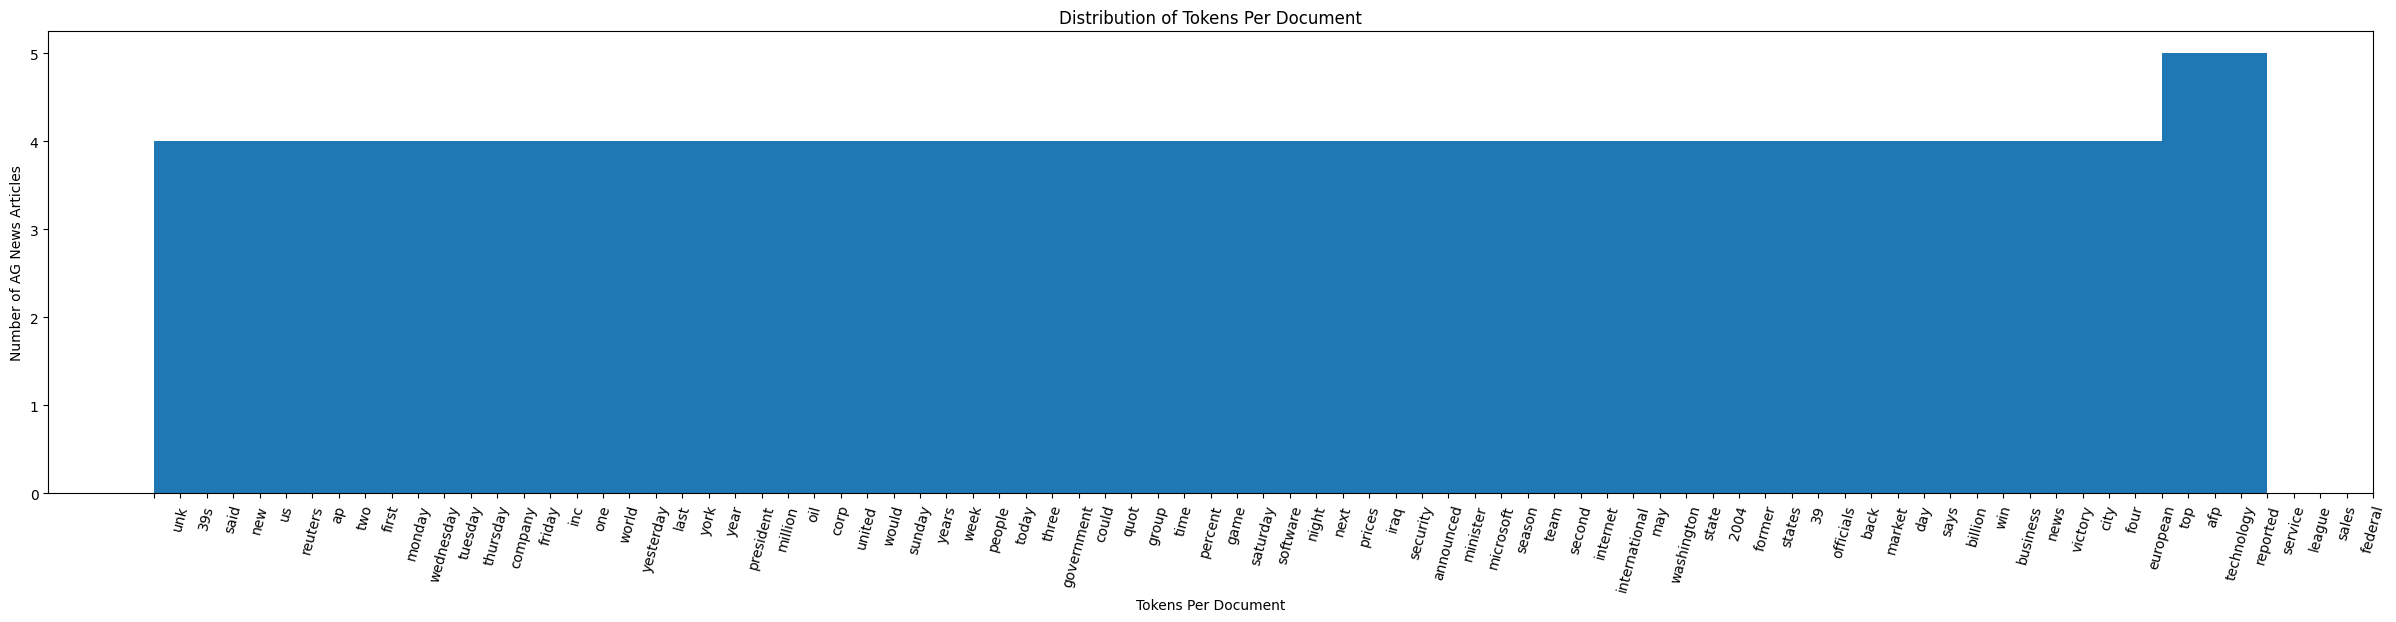

In [18]:
# Plot the histogram
plt.figure(figsize=(30, 6))
plt.hist(vocab_filtered, bins=20, range=(0, 80))
plt.xticks(rotation=75)
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
plt.title("Distribution of Tokens Per Document")
plt.show()

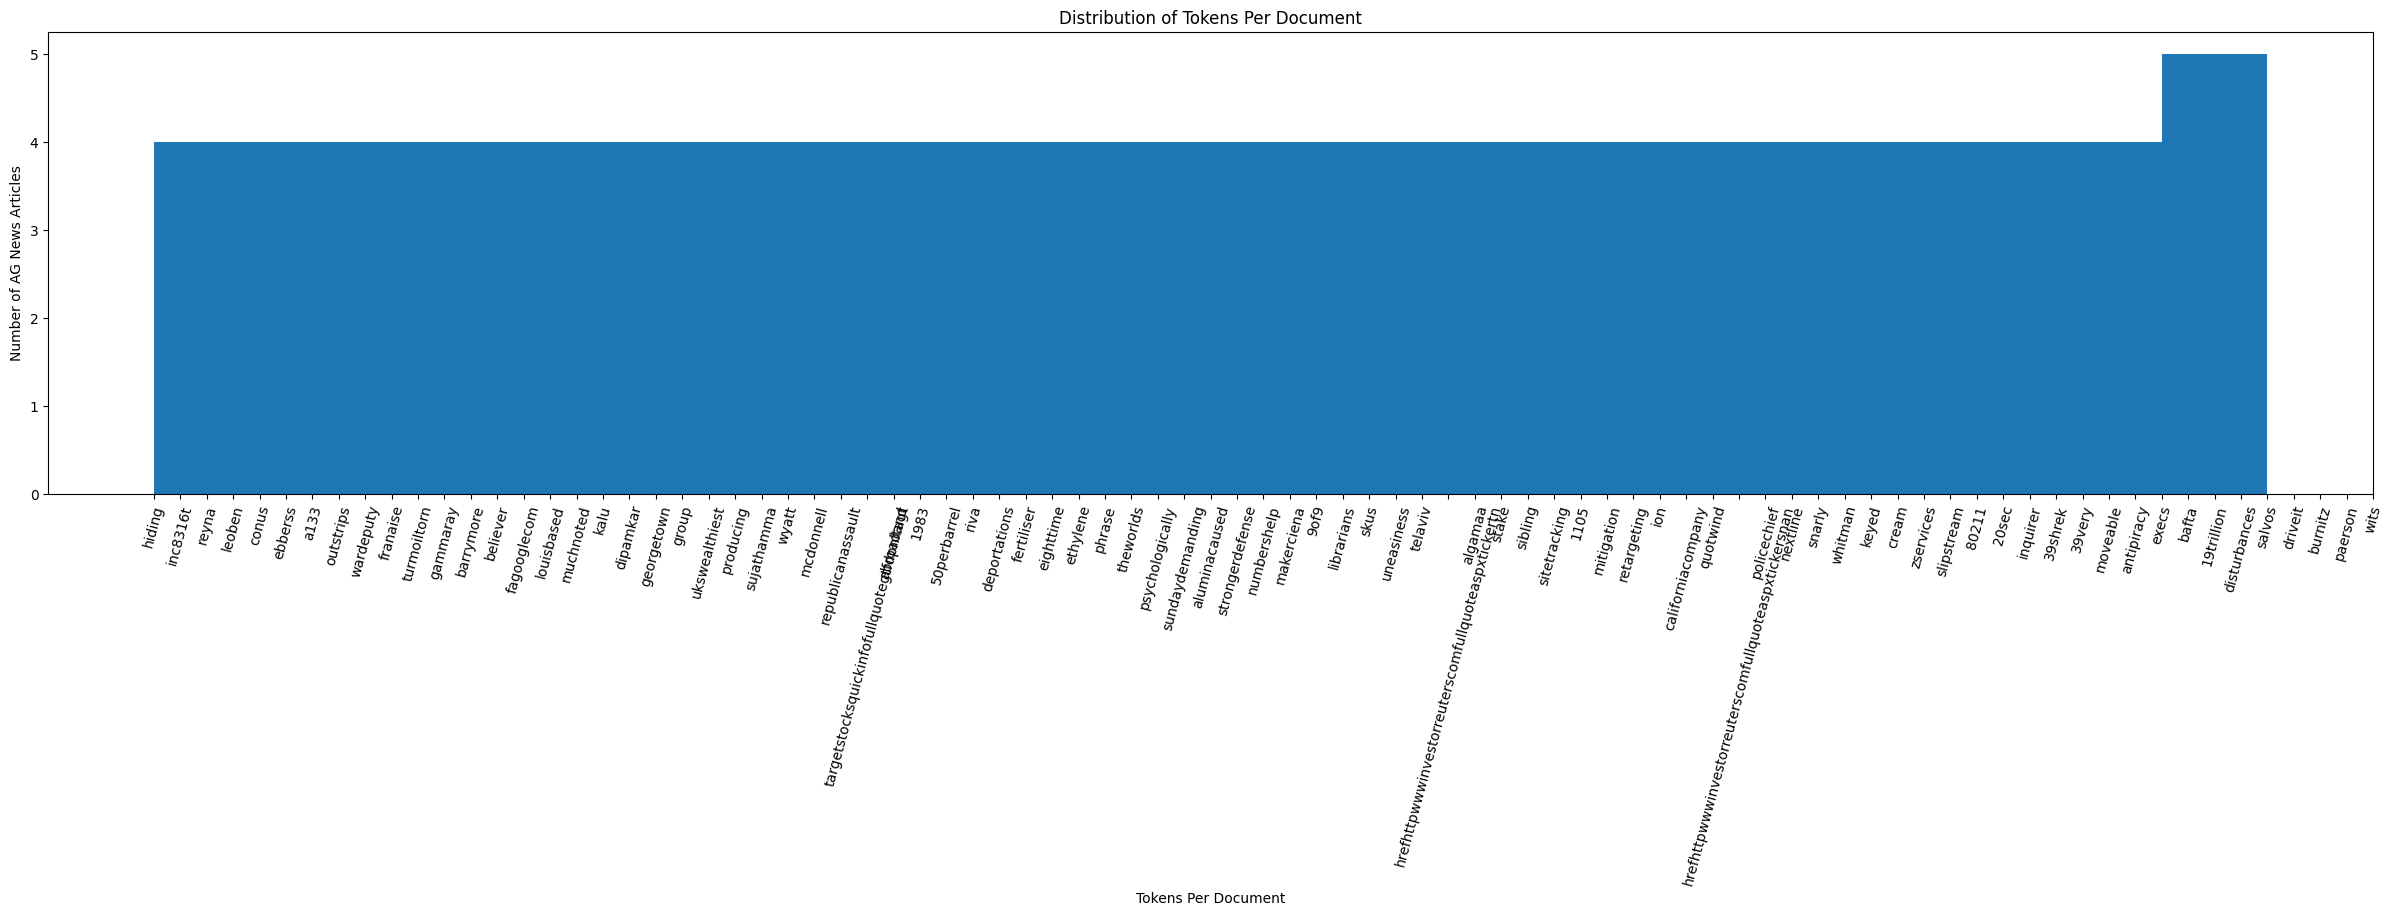

In [19]:
# Plot the histogram
plt.figure(figsize=(30, 6))
plt.hist(vocab_filtered_1, bins=20, range=(0, 80))
plt.xticks(rotation=75)
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
plt.title("Distribution of Tokens Per Document")
plt.show()

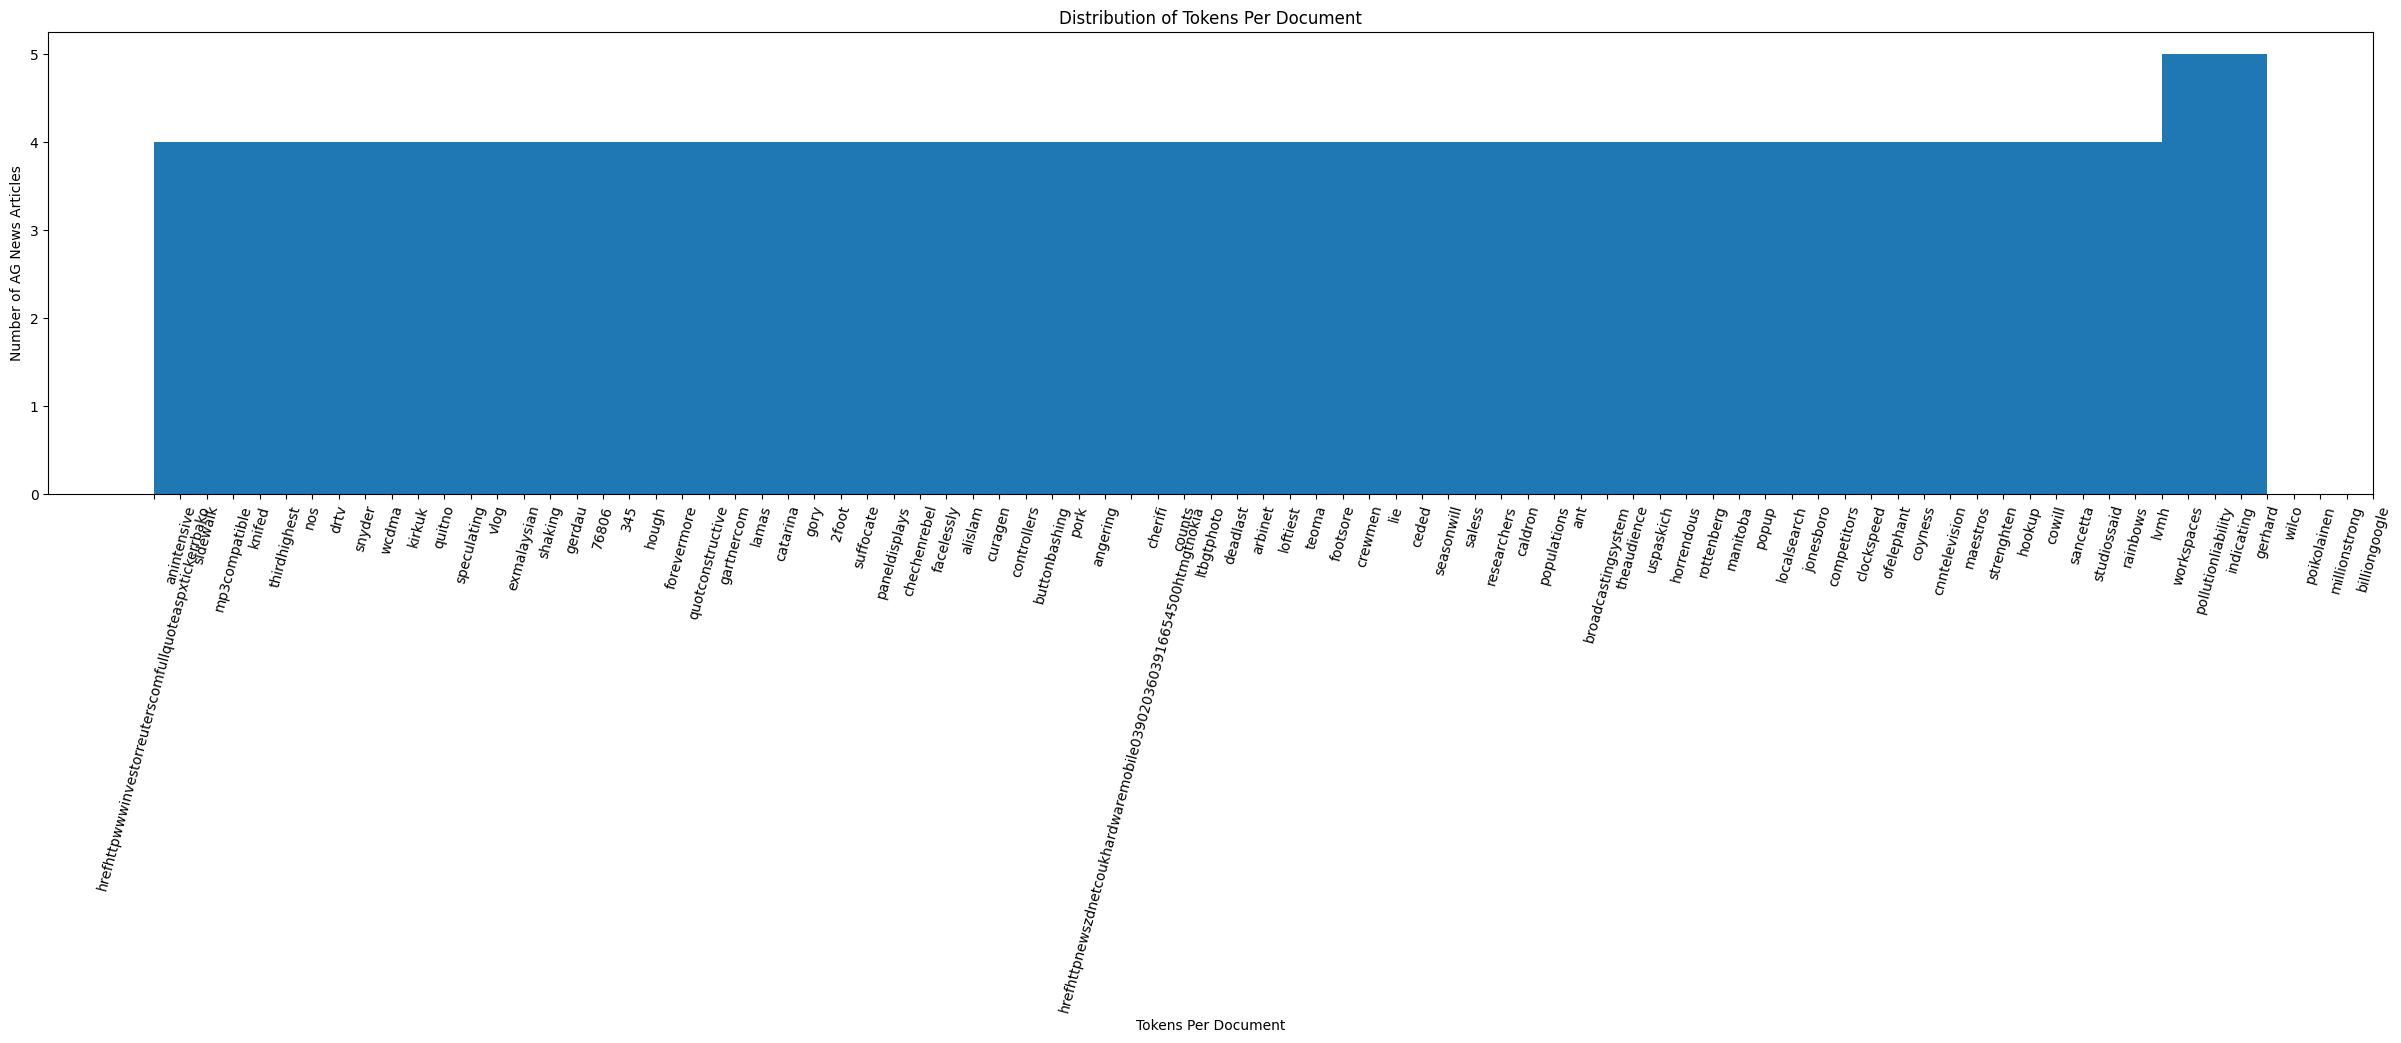

In [20]:
# Plot the histogram
plt.figure(figsize=(30, 6))
plt.hist(vocab_filtered_2, bins=20, range=(0, 80))
plt.xticks(rotation=75)
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
plt.title("Distribution of Tokens Per Document")
plt.show()

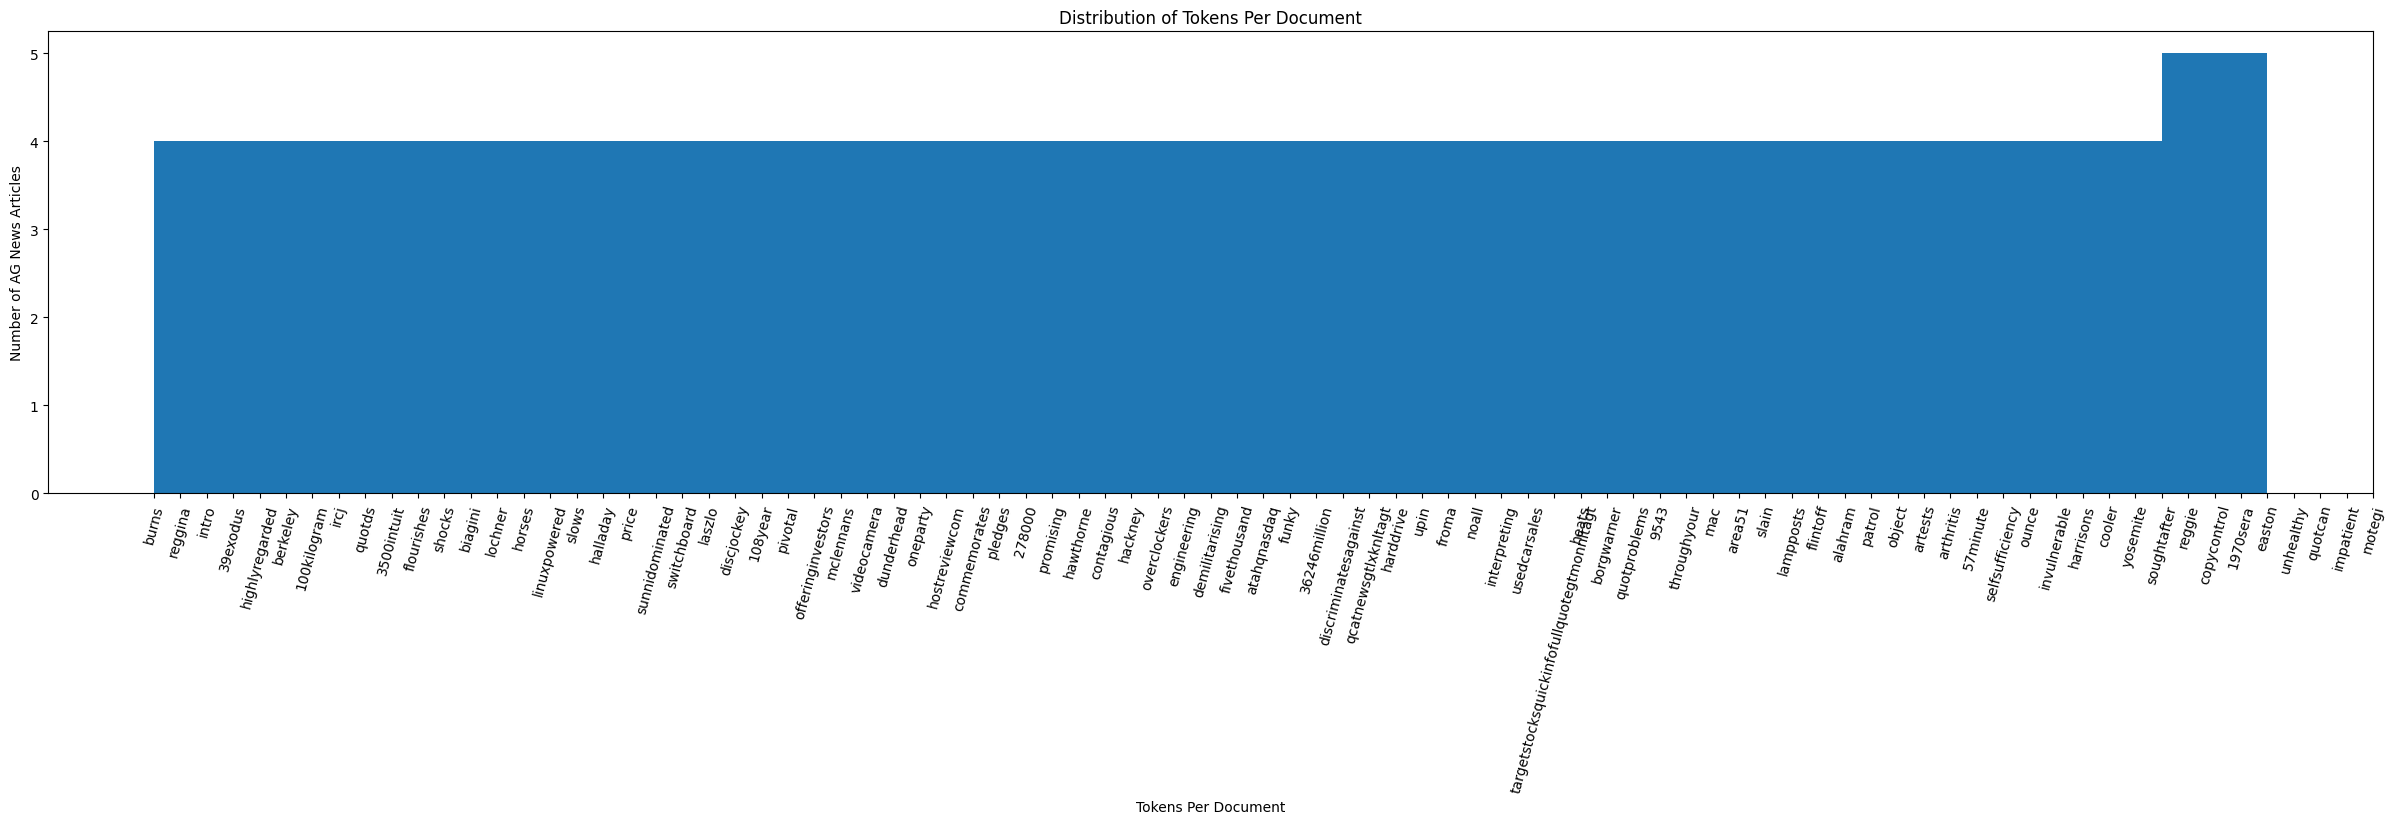

In [21]:
# Plot the histogram
plt.figure(figsize=(30, 6))
plt.hist(vocab_filtered_3, bins=20, range=(0, 80))
plt.xticks(rotation=75)
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
plt.title("Distribution of Tokens Per Document")
plt.show()

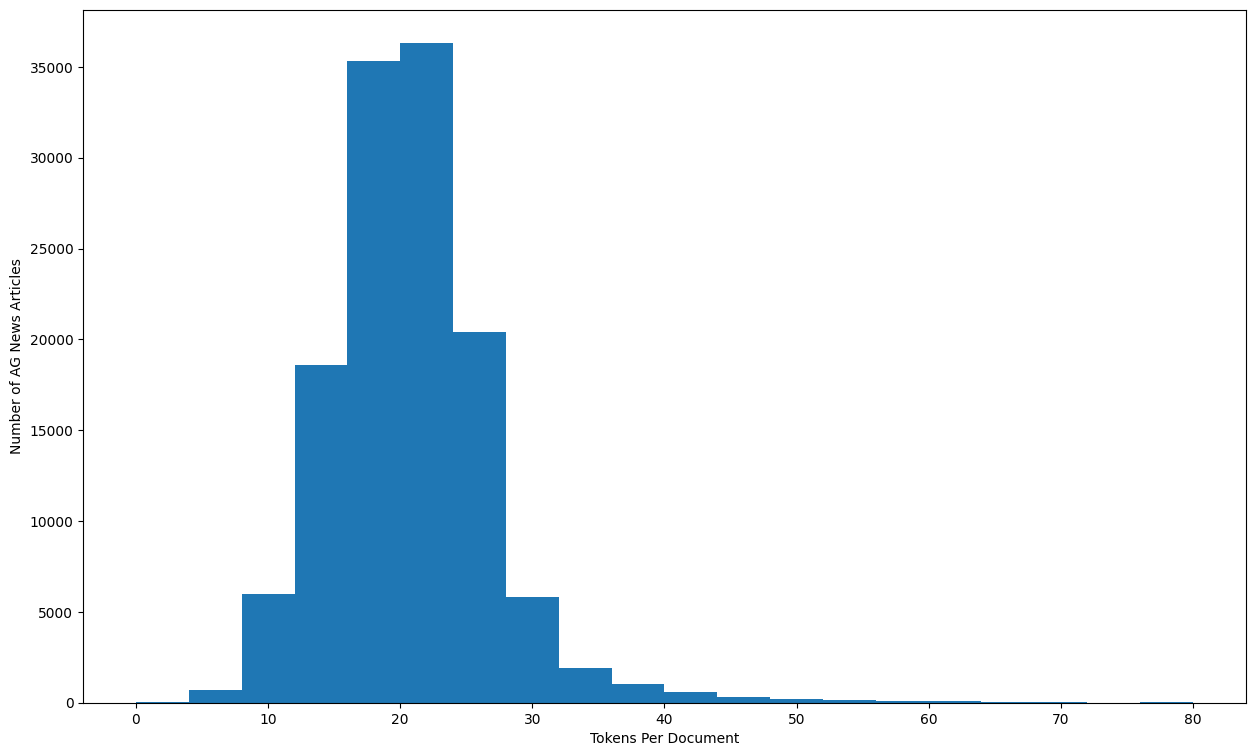

In [22]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,80))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

LSTM

In [23]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

# plotting functions
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [24]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

W0220 00:22:32.845220 136909119729664 download_and_prepare.py:46] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.datasets.ag_news_subset.ag_news_subset_dataset_builder
INFO[dataset_info.py]: Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
INFO[build.py]: download_and_prepare for dataset ag_news_subset/1.0.0...
INFO[dataset_builder.py]: Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
INFO[build.py]: Dataset generation complete...

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided b

In [27]:
## preparing integer sequence dataset
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")
max_length = 96
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [26]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("LSTM.h5")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 330244 (1.26 MB)
Trainable params: 330244 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 497s 139ms/step - loss: 0.4150 - accuracy: 0.8534 - val_loss: 0.3939 - val_accuracy: 0.8605
Epoch 3/200
3563/3563 [==============================] - 492s 138ms/step - loss: 0.3990 - accuracy: 0.8593 - val_loss: 0.3902 - val_accuracy: 0.8637
Epoch 4/200
3563/3563 [==============================] - 489s 137ms/step - loss: 0.3867 - accuracy: 0.8638 - val_loss: 0.3831 - val_accuracy: 0.8637
Epoch 5/200
3563/3563 [==============================] - 490s 138ms/step - loss: 0.3758 - accuracy: 0.8677 - val_loss: 0.3814 - val_accuracy: 0.8647
Epoch 6/200
3563/3563 [==============================] - 497s 140ms/step - loss: 0.3667 - accuracy: 0.8707 - val_loss: 0.3824 - val_accuracy: 0.8662
Epoch 7/200
3563/3563 [==============================] - 491s 138ms/step - loss: 0.3595 - accuracy: 0.8742 - val_loss: 0.3850 - val_accuracy: 0.8645
Epoch 8/200
3563/3563 [==============================] - 489s 137ms/step - loss: 0.3524 - accuracy: 0.8759 - val_loss:

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,0.376,0.868,0.381,0.865
5,0.367,0.871,0.382,0.866
6,0.360,0.874,0.385,0.864
7,0.352,0.876,0.386,0.864
8,0.344,0.879,0.394,0.863


<ipython-input-23-dcbd5df6b796>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


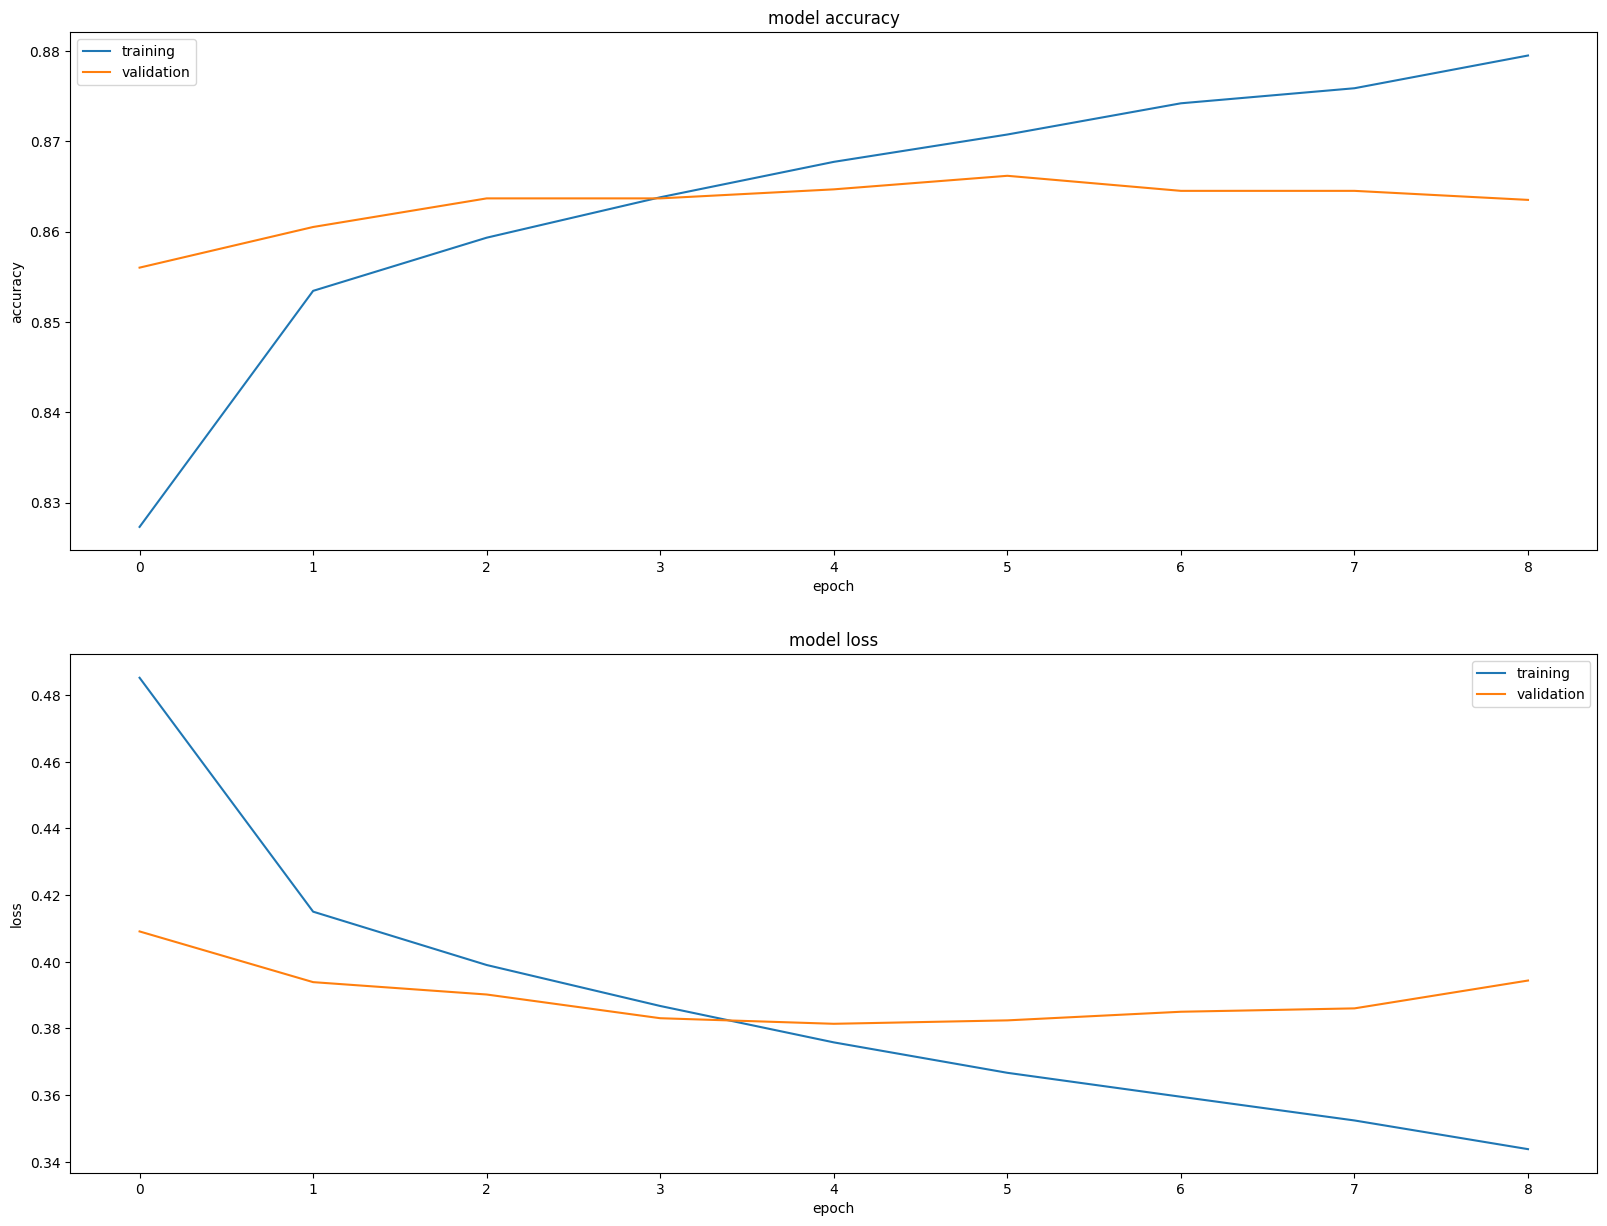

In [29]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [31]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)


In [31]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1900
           1       0.92      0.93      0.92      1900
           2       0.85      0.82      0.83      1900
           3       0.81      0.84      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8631578947368421
Root Mean Square Error: 0.6573471405261414


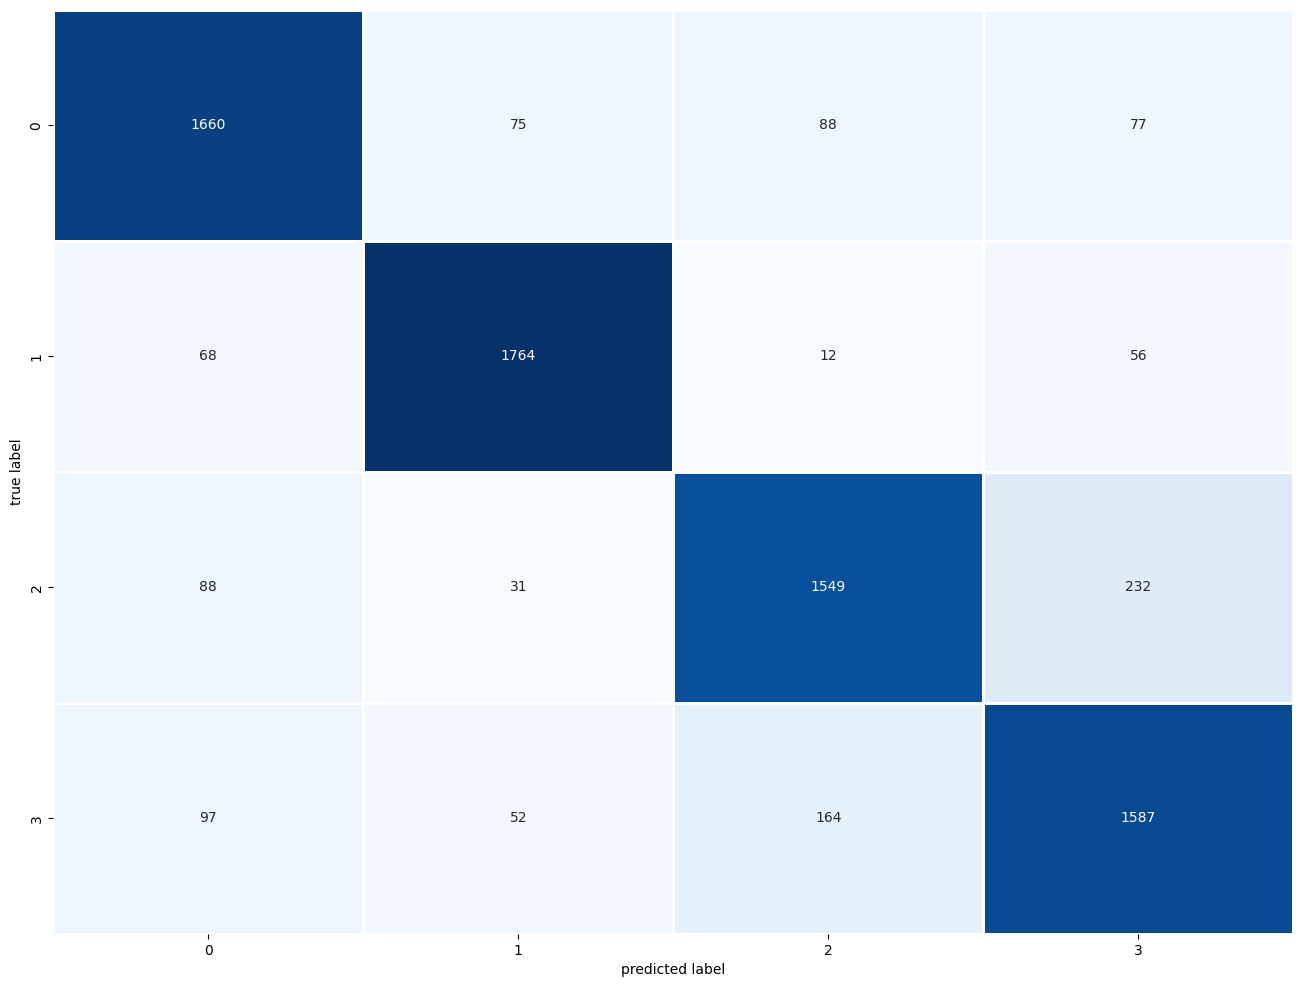

In [32]:
plot_confusion_matrix(y_test,pred_classes)


#RNN

In [33]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the RNN model with the full vocab
def create_rnn_model(vocab_size, embedding_dim, rnn_units, num_classes):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim),
        layers.SimpleRNN(rnn_units),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# parameters
vocab_size = 95827
embedding_dim = 128
rnn_units = 64
num_classes = 2

# Create the RNN model
model = create_rnn_model(vocab_size, embedding_dim, rnn_units, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         12265856  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12278338 (46.84 MB)
Trainable params: 12278338 (46.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
pred_rnn_1 = np.argmax(model.predict(int_test_ds), axis=-1)


238/238 [==============================] - 2s 8ms/step


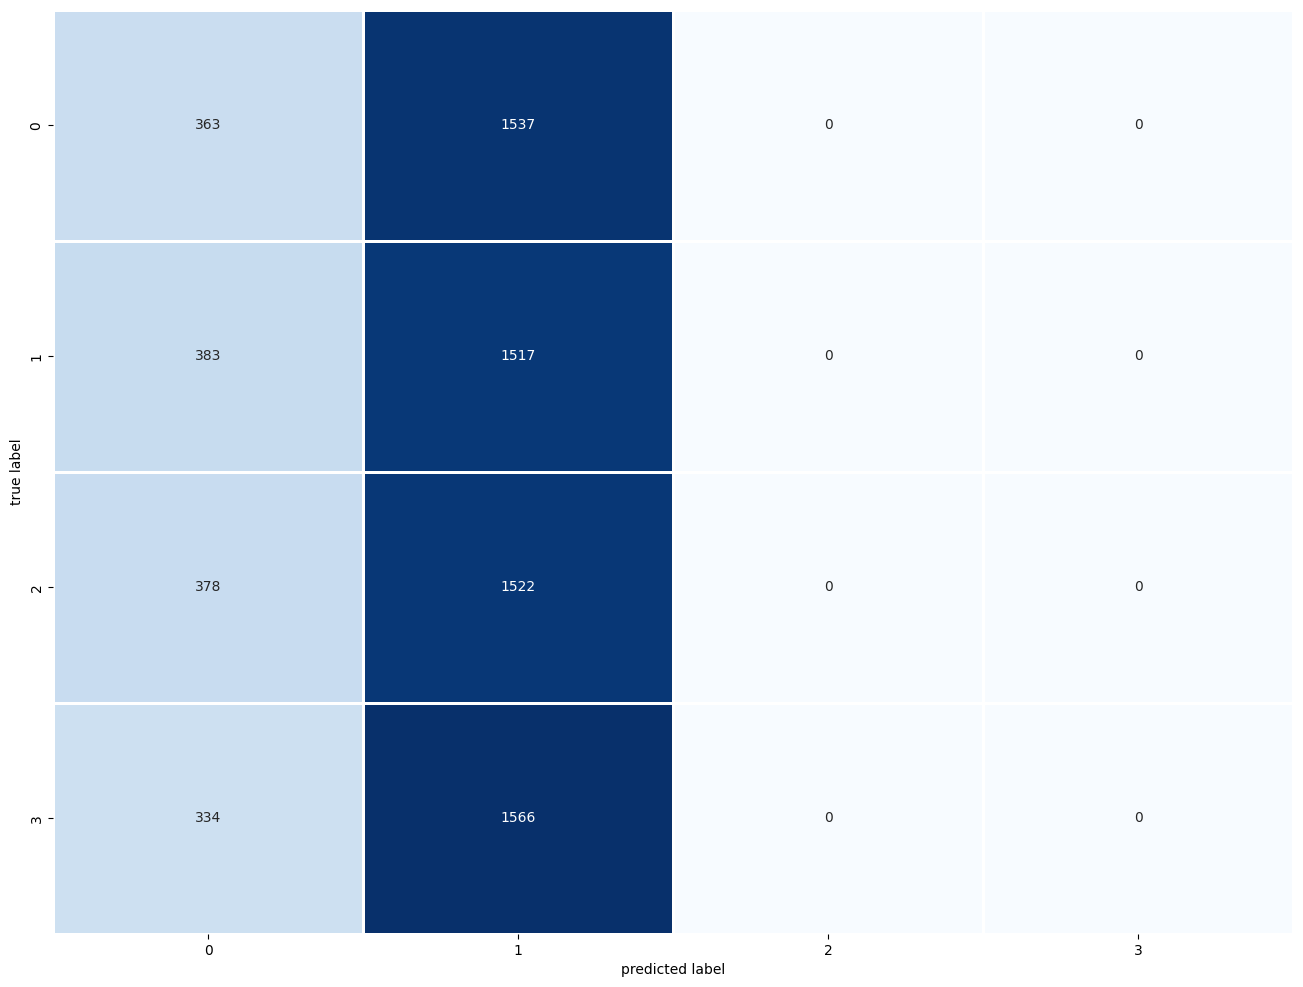

In [35]:
plot_confusion_matrix(y_test, pred_rnn_1)

In [36]:
print_validation_report(y_test, pred_rnn_1)

Classification Report
              precision    recall  f1-score   support

           0       0.25      0.19      0.22      1900
           1       0.25      0.80      0.38      1900
           2       0.00      0.00      0.00      1900
           3       0.00      0.00      0.00      1900

    accuracy                           0.25      7600
   macro avg       0.12      0.25      0.15      7600
weighted avg       0.12      0.25      0.15      7600

Accuracy Score: 0.24736842105263157
Root Mean Square Error: 1.3680566316378941


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
##LSTM
from keras.models import Sequential
from keras.layers import LSTM

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model_2 = Sequential()
model_2.add(LSTM(4, input_shape=(None, 1)))  # Specify input_shape as a tuple (None, input_dim)
model_2.add(Dense(2))

# Compile the model
model_2.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
Total params: 106 (424.00 Byte)
Trainable params: 106 (424.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
pred_lstm_1 = np.argmax(model_2.predict(int_test_ds), axis=-1)


238/238 [==============================] - 2s 7ms/step


In [40]:
print_validation_report(y_test, pred_lstm_1)

Classification Report
              precision    recall  f1-score   support

           0       0.25      1.00      0.40      1900
           1       0.00      0.00      0.00      1900
           2       0.00      0.00      0.00      1900
           3       0.00      0.00      0.00      1900

    accuracy                           0.25      7600
   macro avg       0.06      0.25      0.10      7600
weighted avg       0.06      0.25      0.10      7600

Accuracy Score: 0.25
Root Mean Square Error: 1.8708286933869707


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


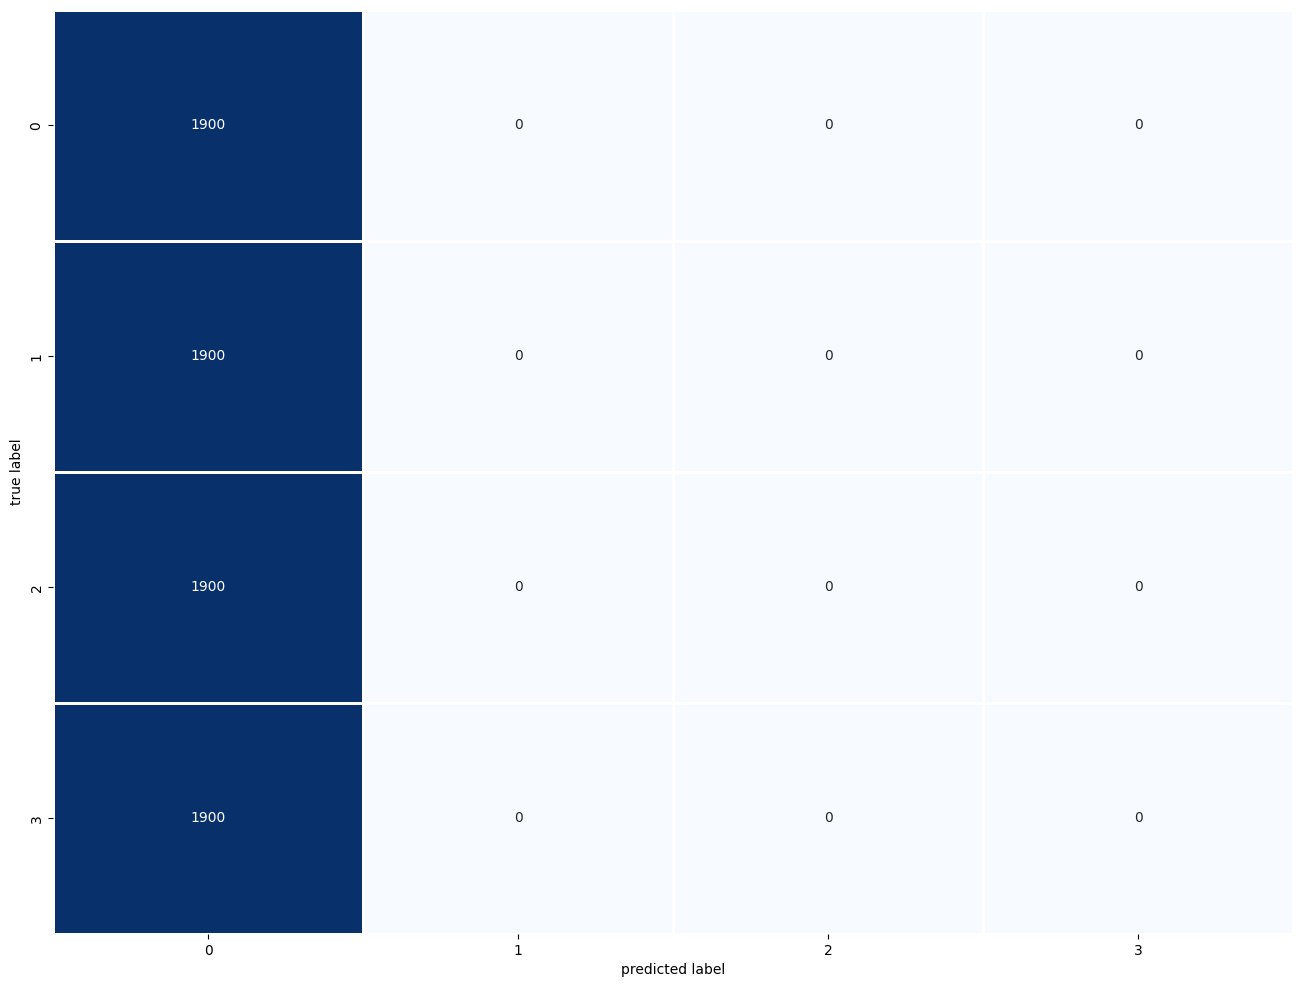

In [41]:
plot_confusion_matrix(y_test, pred_lstm_1)

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, Model

tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# embedding layer
embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)

# bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(32))(embedded)

# dropout layer
x = layers.Dropout(0.5)(x)

# output layer
outputs = layers.Dense(4, activation="softmax")(x)

# Define the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print the model summary
model.summary()

# callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

# train the model
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

# Load the best model from the checkpoint
model = tf.keras.models.load_model("LSTM.h5")

# Evaluate the model on the test set
test_accuracy = model.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 330244 (1.26 MB)
Trainable params: 330244 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
3563/3563 [==============================] - 496s 139ms/step - loss: 0.4154 - accuracy: 0.8532 - val_loss: 0.3904 - val_accuracy: 0.8623
Epoch 3/200
3563/3563 [==============================] - 498s 140ms/step - loss: 0.3982 - accuracy: 0.8589 - val_loss: 0.3833 - val_accuracy: 0.8617
Epoch 4/200
3563/3563 [==============================] - 495s 139ms/step - loss: 0.3831 - accuracy: 0.8643 - val_loss: 0.3861 - val_accuracy: 0.8632
Epoch 5/200
3563/3563 [==============================] - 502s 141ms/step - loss: 0.3728 - accuracy: 0.8677 - val_loss: 0.3795 - val_accuracy: 0.8683
Epoch 6/200
3563/3563 [==============================] - 497s 139ms/step - loss: 0.3636 - accuracy: 0.8714 - val_loss: 0.3833 - val_accuracy: 0.8693
Epoch 7/200
3563/3563 [==============================] - 497s 140ms/step - loss: 0.3562 - accuracy: 0.8746 - val_loss: 0.3814 - val_accuracy: 0.8685
Epoch 8/200
3563/3563 [==============================] - 489s 137ms/step - loss: 0.3472 - accuracy: 0.8787

In [43]:
pred_lstm_2 = np.argmax(model.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_lstm_2)

238/238 [==============================] - 10s 33ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1900
           1       0.92      0.92      0.92      1900
           2       0.86      0.80      0.83      1900
           3       0.81      0.84      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8617105263157895
Root Mean Square Error: 0.6650089037789367


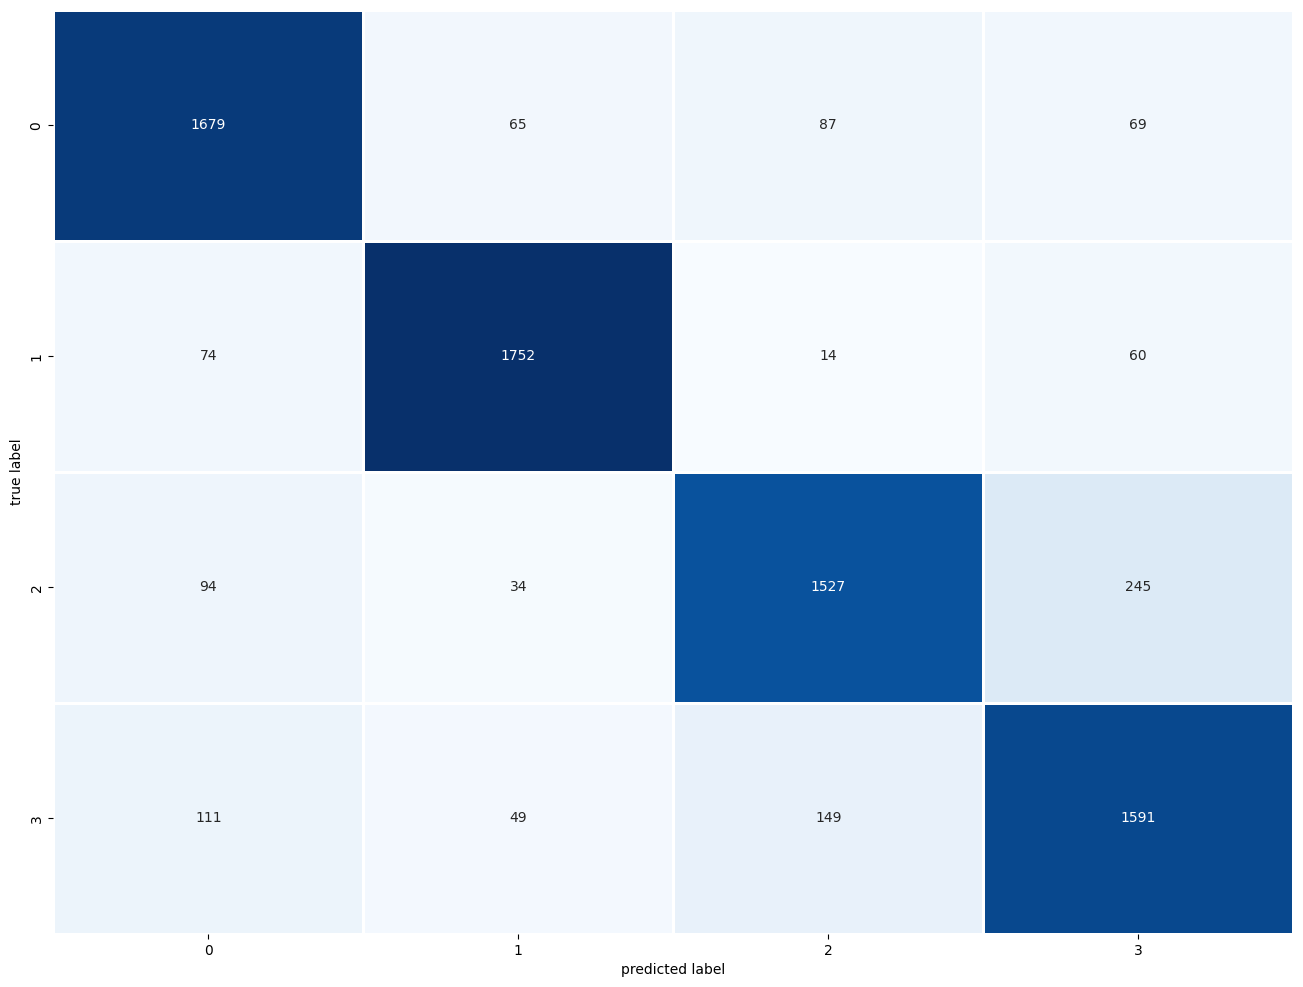

In [44]:
plot_confusion_matrix(y_test, pred_lstm_2)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Clear previous session
tf.keras.backend.clear_session()

# Define the input layer
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Define the embedding layer
embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)

# Define the LSTM layer
x = layers.LSTM(32)(embedded)

# Apply dropout layer
x = layers.Dropout(0.5)(x)

# Define the output layer
outputs = layers.Dense(4, activation="softmax")(x)

# Define the model
model_4 = tf.keras.Model(inputs, outputs)

# Compile the model
model_4.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print the model summary
model_4.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

# Train the model
history = model_4.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

# Load the best model from the checkpoint
model_4 = tf.keras.models.load_model("LSTM.h5")

# Evaluate the model on the test set
test_accuracy = model_4.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 lstm (LSTM)                 (None, 32)                36992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 293124 (1.12 MB)
Trainable params: 293124 (1.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
3563/3563 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 273s 77ms/step - loss: 0.4407 - accuracy: 0.8510 - val_loss: 0.4035 - val_accuracy: 0.8598
Epoch 3/200
3563/3563 [==============================] - 276s 78ms/step - loss: 0.4198 - accuracy: 0.8566 - val_loss: 0.3959 - val_accuracy: 0.8633
Epoch 4/200
3563/3563 [==============================] - 276s 78ms/step - loss: 0.4062 - accuracy: 0.8605 - val_loss: 0.3929 - val_accuracy: 0.8633
Epoch 5/200
3563/3563 [==============================] - 276s 77ms/step - loss: 0.3946 - accuracy: 0.8644 - val_loss: 0.3925 - val_accuracy: 0.8637
Epoch 6/200
3563/3563 [==============================] - 272s 76ms/step - loss: 0.3866 - accuracy: 0.8668 - val_loss: 0.3952 - val_accuracy: 0.8650
Epoch 7/200
3563/3563 [==============================] - 271s 76ms/step - loss: 0.3794 - accuracy: 0.8692 - val_loss: 0.3997 - val_accuracy: 0.8607
Epoch 8/200
3563/3563 [==============================] - 275s 77ms/step - loss: 0.3731 - accuracy: 0.8720 - val_loss: 0.3917

In [46]:
pred_lstm_3 = np.argmax(model_4.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_lstm_3)

238/238 [==============================] - 5s 15ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1900
           1       0.93      0.91      0.92      1900
           2       0.85      0.81      0.83      1900
           3       0.81      0.83      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8593421052631579
Root Mean Square Error: 0.6616367265310601


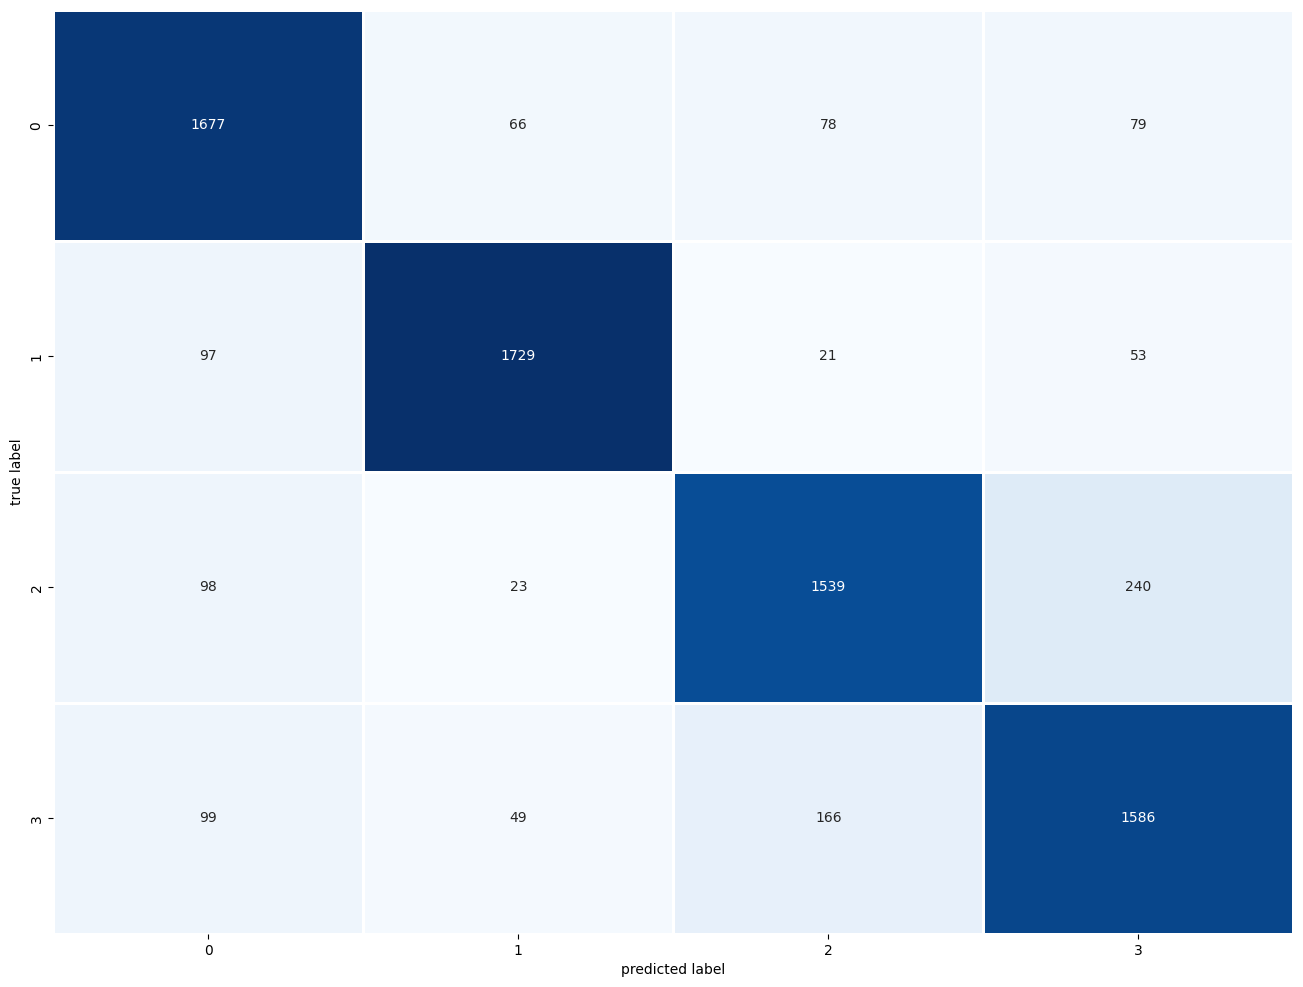

In [47]:
plot_confusion_matrix(y_test, pred_lstm_3)

In [48]:
# model 5
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(None,), dtype="int64")

embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)


x = layers.LSTM(32)(embedded)
x = layers.LSTM(16)(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(4, activation="softmax")(x)
model_5 = tf.keras.Model(inputs, outputs)

# Compile the model
model_5.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print the model summary
model_5.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

# Train the model
history = model_5.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

# Load the best model from the checkpoint
model_5 = tf.keras.models.load_model("LSTM.h5")

# Evaluate the model on the test set
test_accuracy = model_5.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 lstm_1 (LSTM)               (None, 16)                17472     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 273540 (1.04 MB)
Trainable params: 273540 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
3563/3563 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 242s 68ms/step - loss: 0.4689 - accuracy: 0.8474 - val_loss: 0.4093 - val_accuracy: 0.8592
Epoch 3/200
3563/3563 [==============================] - 229s 64ms/step - loss: 0.4505 - accuracy: 0.8519 - val_loss: 0.4015 - val_accuracy: 0.8608
Epoch 4/200
3563/3563 [==============================] - 230s 64ms/step - loss: 0.4392 - accuracy: 0.8549 - val_loss: 0.3996 - val_accuracy: 0.8608
Epoch 5/200
3563/3563 [==============================] - 230s 65ms/step - loss: 0.4318 - accuracy: 0.8560 - val_loss: 0.3985 - val_accuracy: 0.8608
Epoch 6/200
3563/3563 [==============================] - 230s 64ms/step - loss: 0.4251 - accuracy: 0.8584 - val_loss: 0.3981 - val_accuracy: 0.8623
Epoch 7/200
3563/3563 [==============================] - 229s 64ms/step - loss: 0.4180 - accuracy: 0.8604 - val_loss: 0.4061 - val_accuracy: 0.8627
Epoch 8/200
3563/3563 [==============================] - 229s 64ms/step - loss: 0.4146 - accuracy: 0.8623 - val_loss: 0.4018

238/238 [==============================] - 6s 13ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1900
           1       0.92      0.92      0.92      1900
           2       0.85      0.80      0.83      1900
           3       0.80      0.84      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8563157894736843
Root Mean Square Error: 0.6782329983125268


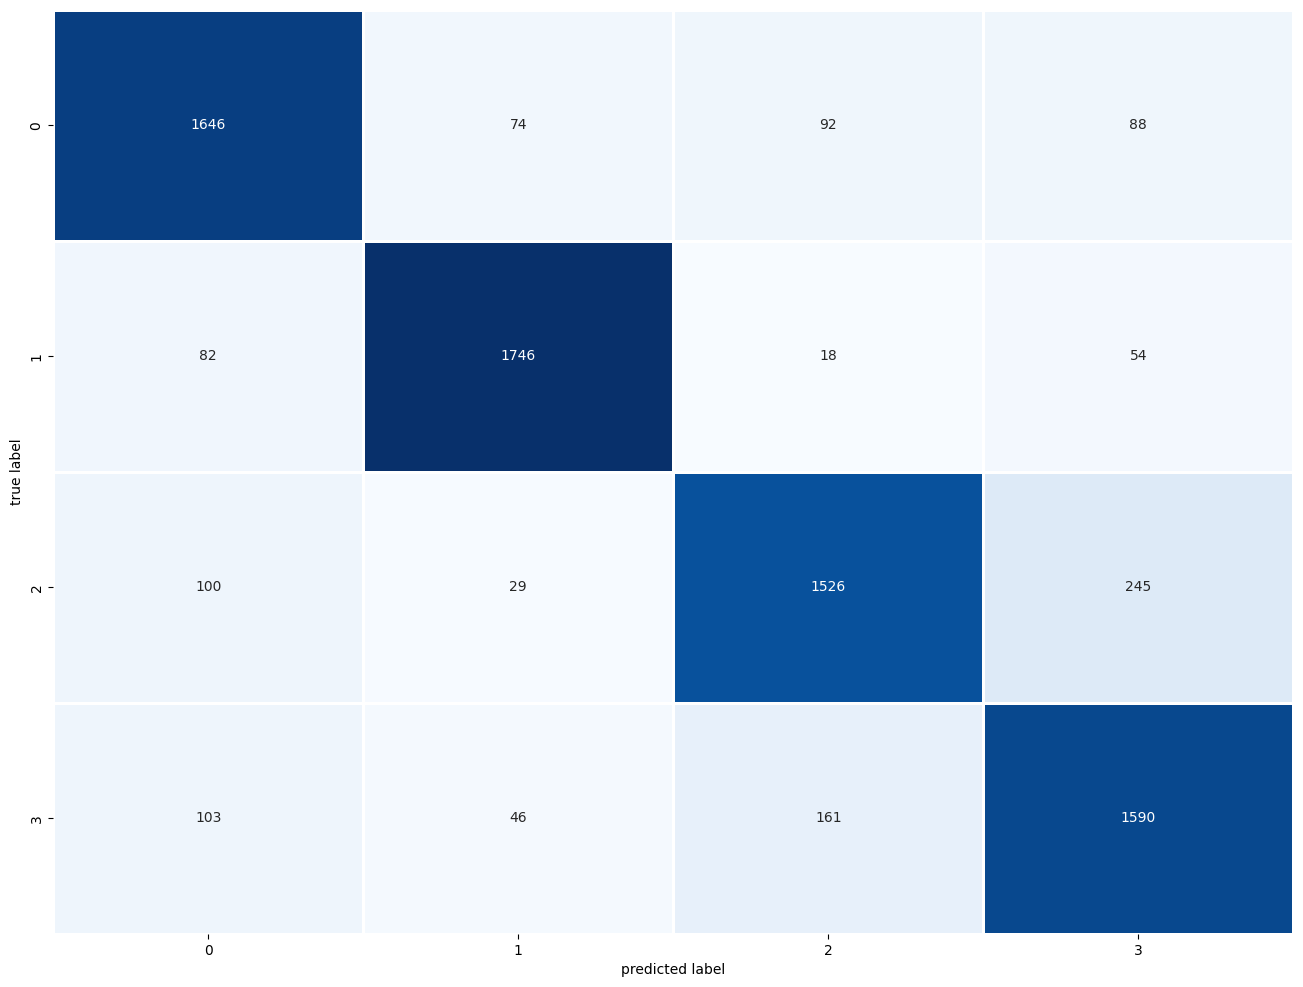

In [49]:
pred_lstm_4 = np.argmax(model_5.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_lstm_4)

plot_confusion_matrix(y_test, pred_lstm_4)

In [50]:
# model 6
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(None,), dtype="int64")

embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.LSTM(32)(embedded)
x = layers.LSTM(16)(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(4, activation="softmax")(x)
model_6 = tf.keras.Model(inputs, outputs)

# Compile the model
model_6.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print the model summary
model_6.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

# Train the model
history = model_5.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

# Load the best model from the checkpoint
model_6 = tf.keras.models.load_model("LSTM.h5")

# Evaluate the model on the test set
test_accuracy = model_6.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 lstm_2 (LSTM)               (None, 16)                17472     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 273540 (1.04 MB)
Trainable params: 273540 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
3563/3563 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
3563/3563 [==============================] - 228s 64ms/step - loss: 0.4138 - accuracy: 0.8622 - val_loss: 0.3951 - val_accuracy: 0.8650
Epoch 3/200
3563/3563 [==============================] - 229s 64ms/step - loss: 0.4110 - accuracy: 0.8639 - val_loss: 0.4037 - val_accuracy: 0.8650
Epoch 4/200
3563/3563 [==============================] - 228s 64ms/step - loss: 0.4056 - accuracy: 0.8647 - val_loss: 0.4068 - val_accuracy: 0.8658
Epoch 5/200
3563/3563 [==============================] - 230s 64ms/step - loss: 0.4026 - accuracy: 0.8665 - val_loss: 0.4060 - val_accuracy: 0.8645
Epoch 6/200
3563/3563 [==============================] - 229s 64ms/step - loss: 0.3993 - accuracy: 0.8673 - val_loss: 0.4122 - val_accuracy: 0.8655
Epoch 7/200
238/238 [==============================] - 5s 14ms/step - loss: 0.4133 - accuracy: 0.8575
Test accuracy: 0.858


238/238 [==============================] - 4s 13ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1900
           1       0.92      0.92      0.92      1900
           2       0.86      0.79      0.82      1900
           3       0.79      0.85      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8575
Root Mean Square Error: 0.6704279858497304


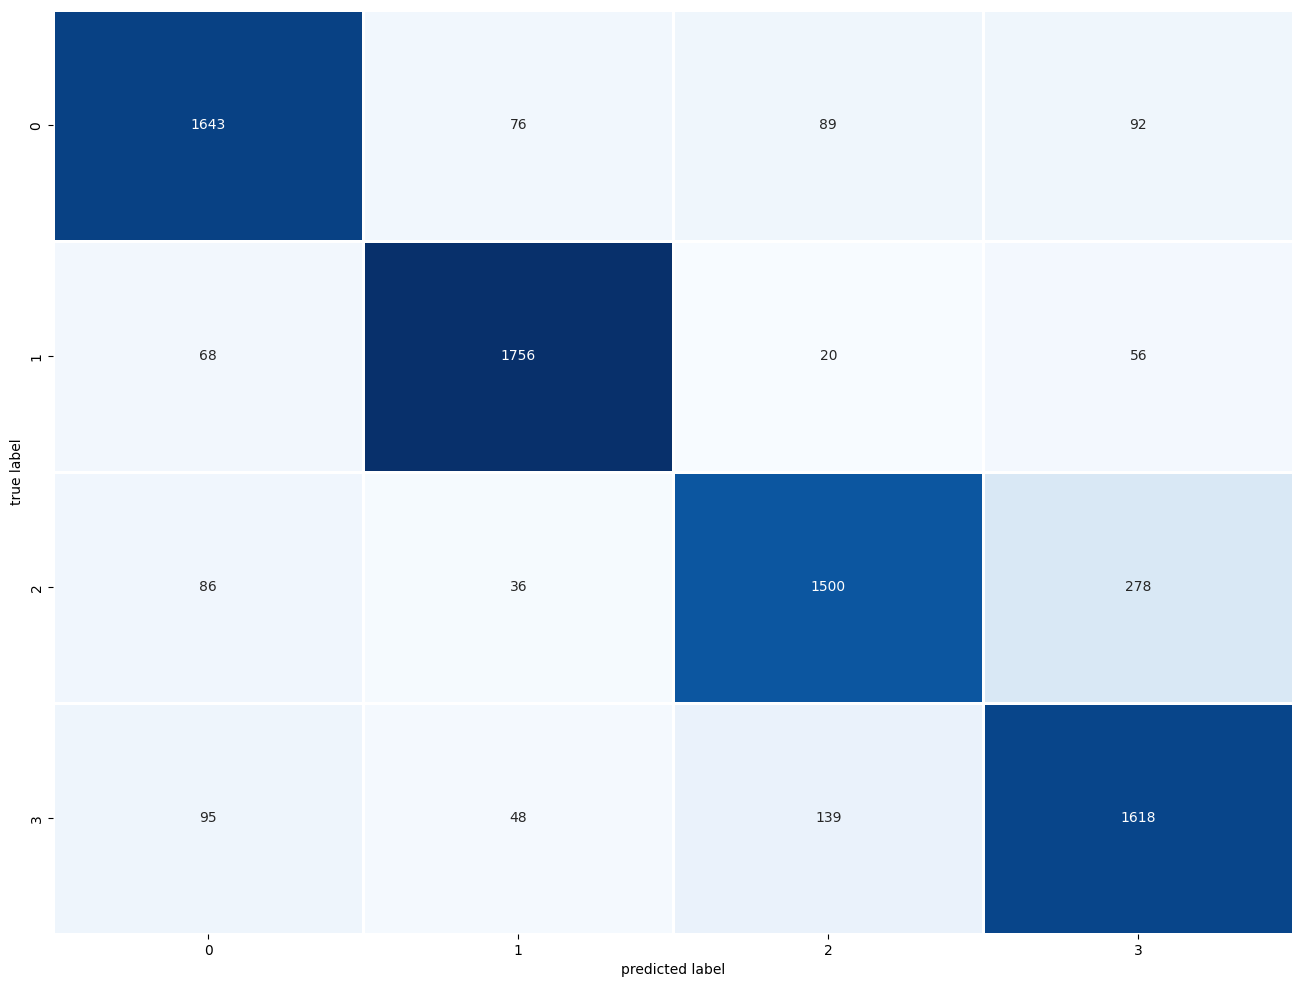

In [51]:
pred_lstm_5 = np.argmax(model_6.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_lstm_5)

plot_confusion_matrix(y_test, pred_lstm_5)

In [52]:
# Experiment 7
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(None,), dtype="int64")

embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)

x = layers.Bidirectional(layers.LSTM(64))(embedded)
x = layers.LSTM(96)(embedded)
x = layers.LSTM(16)(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(4, activation="softmax")(x)
model_7 = tf.keras.Model(inputs, outputs)

# Compile the model
model_7.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print the model summary
model_7.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

# Train the model
history = model_7.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

# Load the best model from the checkpoint
model_7 = tf.keras.models.load_model("LSTM.h5")

# Evaluate the model on the test set
test_accuracy = model_7.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 lstm_2 (LSTM)               (None, 16)                17472     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 273540 (1.04 MB)
Trainable params: 273540 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
3563/3563 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
3563/3563 [==============================] - 227s 64ms/step - loss: 0.4704 - accuracy: 0.8471 - val_loss: 0.4042 - val_accuracy: 0.8598
Epoch 3/200
3563/3563 [==============================] - 225s 63ms/step - loss: 0.4497 - accuracy: 0.8525 - val_loss: 0.3998 - val_accuracy: 0.8613
Epoch 4/200
3563/3563 [==============================] - 226s 63ms/step - loss: 0.4366 - accuracy: 0.8546 - val_loss: 0.3970 - val_accuracy: 0.8600
Epoch 5/200
3563/3563 [==============================] - 226s 63ms/step - loss: 0.4290 - accuracy: 0.8581 - val_loss: 0.3979 - val_accuracy: 0.8588
Epoch 6/200
238/238 [==============================] - 4s 12ms/step - loss: 0.4105 - accuracy: 0.8583
Test accuracy: 0.858


238/238 [==============================] - 5s 14ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1900
           1       0.90      0.94      0.92      1900
           2       0.86      0.80      0.83      1900
           3       0.81      0.83      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8582894736842105
Root Mean Square Error: 0.6675761340377906


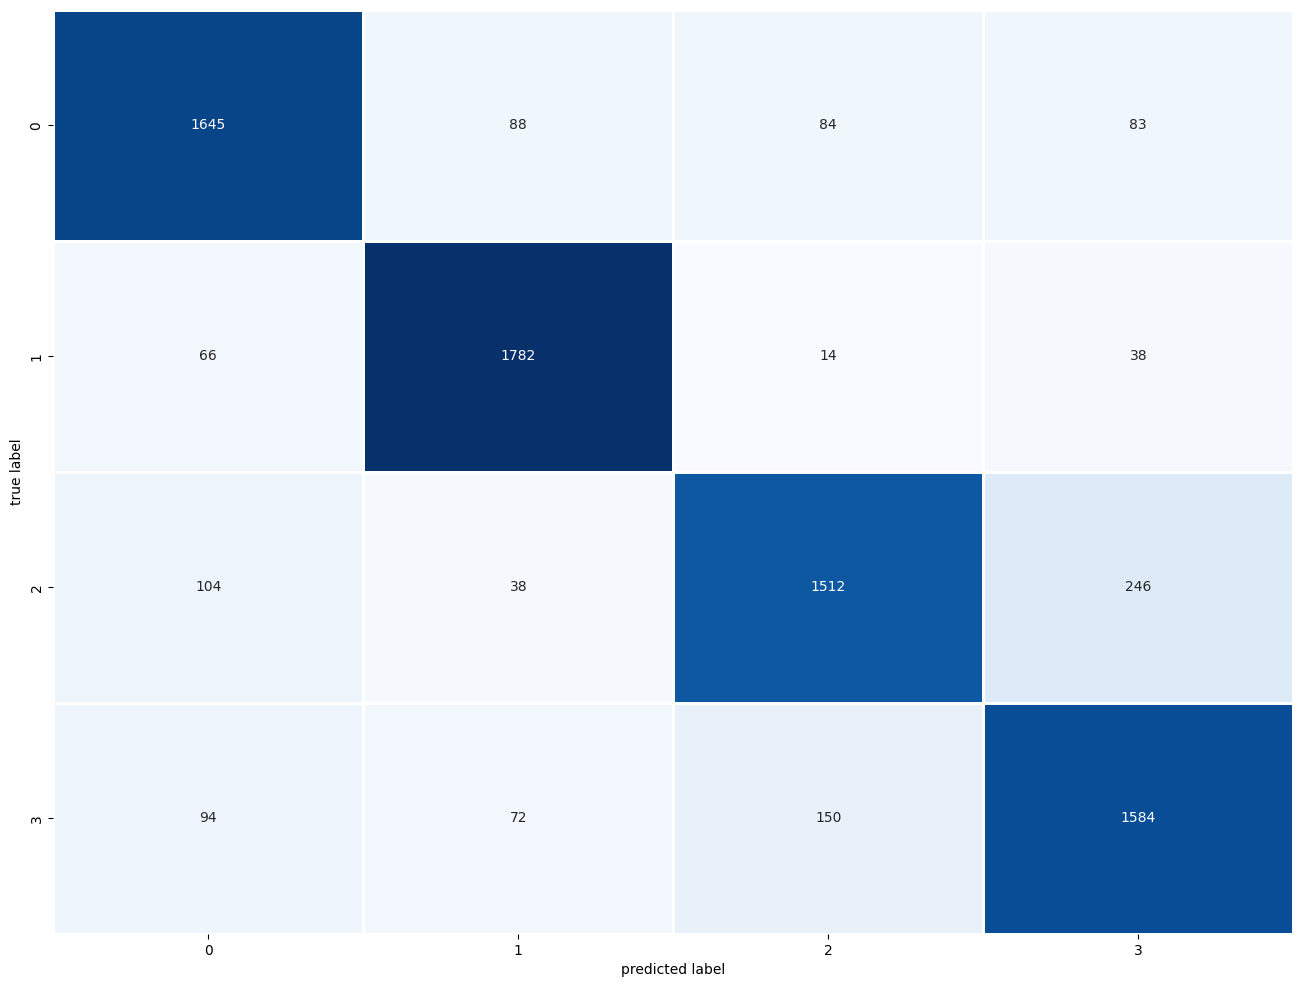

In [53]:
pred_lstm_6 = np.argmax(model_7.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_lstm_6)

plot_confusion_matrix(y_test, pred_lstm_6)

In [54]:
# 1D cnn for language processing
# Experiment 8
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.keras.backend.clear_session()


inputs = tf.keras.Input(shape=(None,), dtype="int64")


embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)

x = layers.Conv1D(32, 5, activation='relu')(embedded)

x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(4, activation="softmax")(x)

model_8 = tf.keras.Model(inputs, outputs)

model_8.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


model_8.summary()

callbacks = [
    ModelCheckpoint("CNN.h5", save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=3)
]

history = model_8.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_8 = tf.keras.models.load_model("CNN.h5")

test_accuracy = model_8.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 conv1d (Conv1D)             (None, None, 32)          40992     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 113s 32ms/step - loss: 0.5153 - accuracy: 0.8297 - val_loss: 0.4374 - val_accuracy: 0.8528
Epoch 3/200
3563/3563 [==============================] - 112s 31ms/step - loss: 0.5001 - accuracy: 0.8332 - val_loss: 0.4356 - val_accuracy: 0.8507
Epoch 4/200
3563/3563 [==============================] - 111s 31ms/step - loss: 0.4893 - accuracy: 0.8351 - val_loss: 0.4360 - val_accuracy: 0.8512
Epoch 5/200
238/238 [==============================] - 2s 7ms/step - loss: 0.4441 - accuracy: 0.8493
Test accuracy: 0.849


238/238 [==============================] - 2s 10ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1900
           1       0.89      0.94      0.91      1900
           2       0.84      0.80      0.82      1900
           3       0.80      0.81      0.80      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.8493421052631579
Root Mean Square Error: 0.6870991654469497


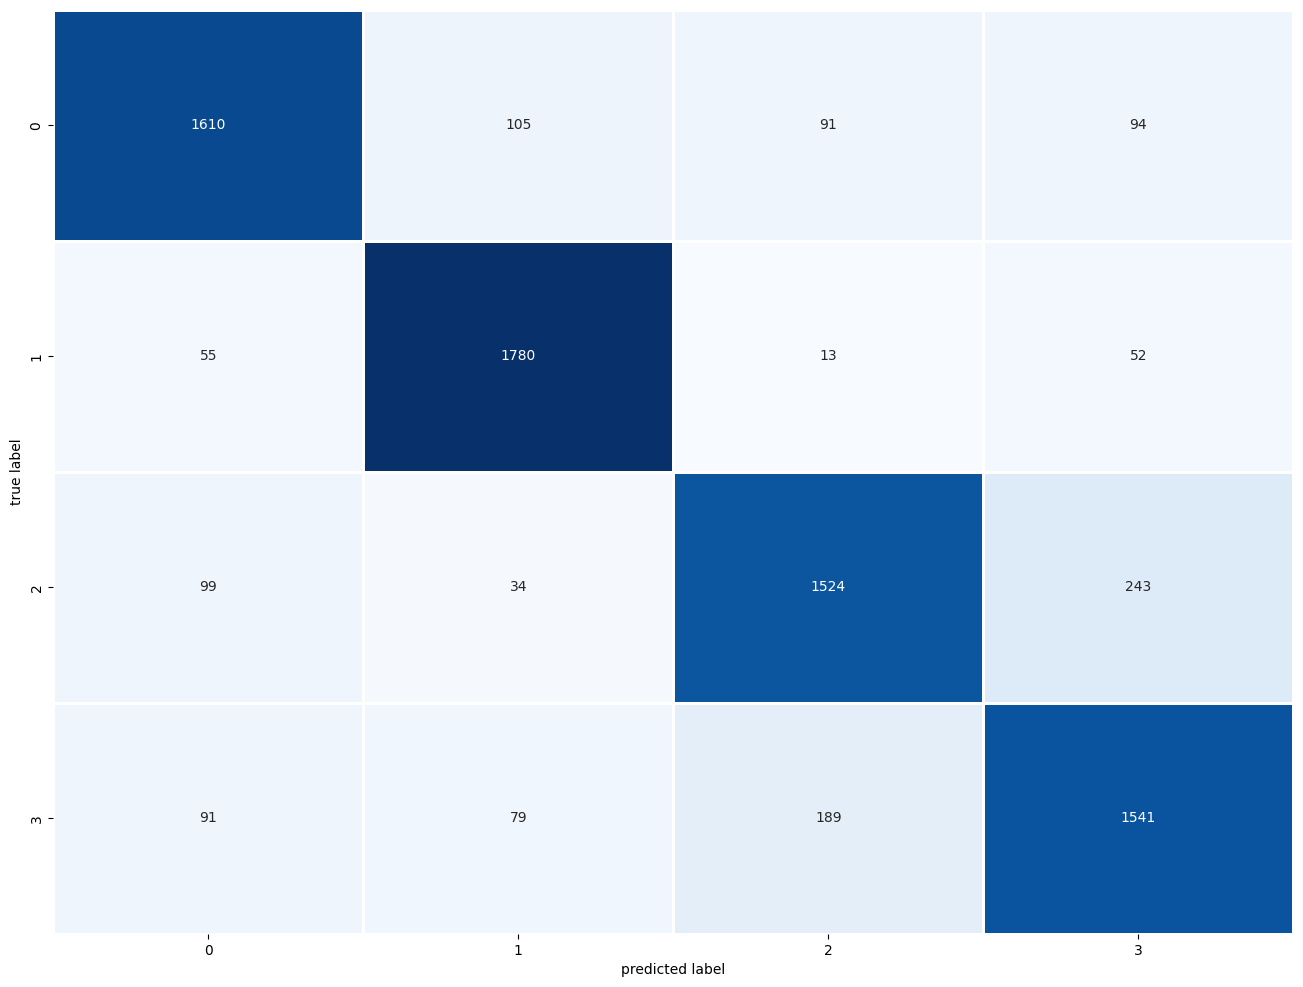

In [55]:
pred_cnn_1 = np.argmax(model_8.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_cnn_1)

plot_confusion_matrix(y_test, pred_cnn_1)

In [28]:
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

max_tokens = 10000

tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")

embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)


x = layers.Conv1D(64, 5, activation='relu')(embedded)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Conv1D(128, 5, activation='relu')(x)
x = layers.Conv1D(128, 5, activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dropout(0.5)(x)


outputs = layers.Dense(4, activation="softmax")(x)


model_9= tf.keras.Model(inputs, outputs)

model_9.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model_9.summary()

callbacks = [
    ModelCheckpoint("CNN.h5", save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=3)
]

history = model_9.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_9 = tf.keras.models.load_model("CNN.h5")

test_accuracy = model_9.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          81984     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          20544     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         41088     
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 353s 99ms/step - loss: 0.4550 - accuracy: 0.8462 - val_loss: 0.4237 - val_accuracy: 0.8580
Epoch 3/200
3563/3563 [==============================] - 364s 102ms/step - loss: 0.4422 - accuracy: 0.8520 - val_loss: 0.4426 - val_accuracy: 0.8542
Epoch 4/200
3563/3563 [==============================] - 349s 98ms/step - loss: 0.4396 - accuracy: 0.8535 - val_loss: 0.4519 - val_accuracy: 0.8505
Epoch 5/200
238/238 [==============================] - 6s 24ms/step - loss: 0.4364 - accuracy: 0.8492
Test accuracy: 0.849


238/238 [==============================] - 5s 22ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1900
           1       0.89      0.93      0.91      1900
           2       0.83      0.80      0.82      1900
           3       0.79      0.82      0.81      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.8492105263157895
Root Mean Square Error: 0.6802669754550318


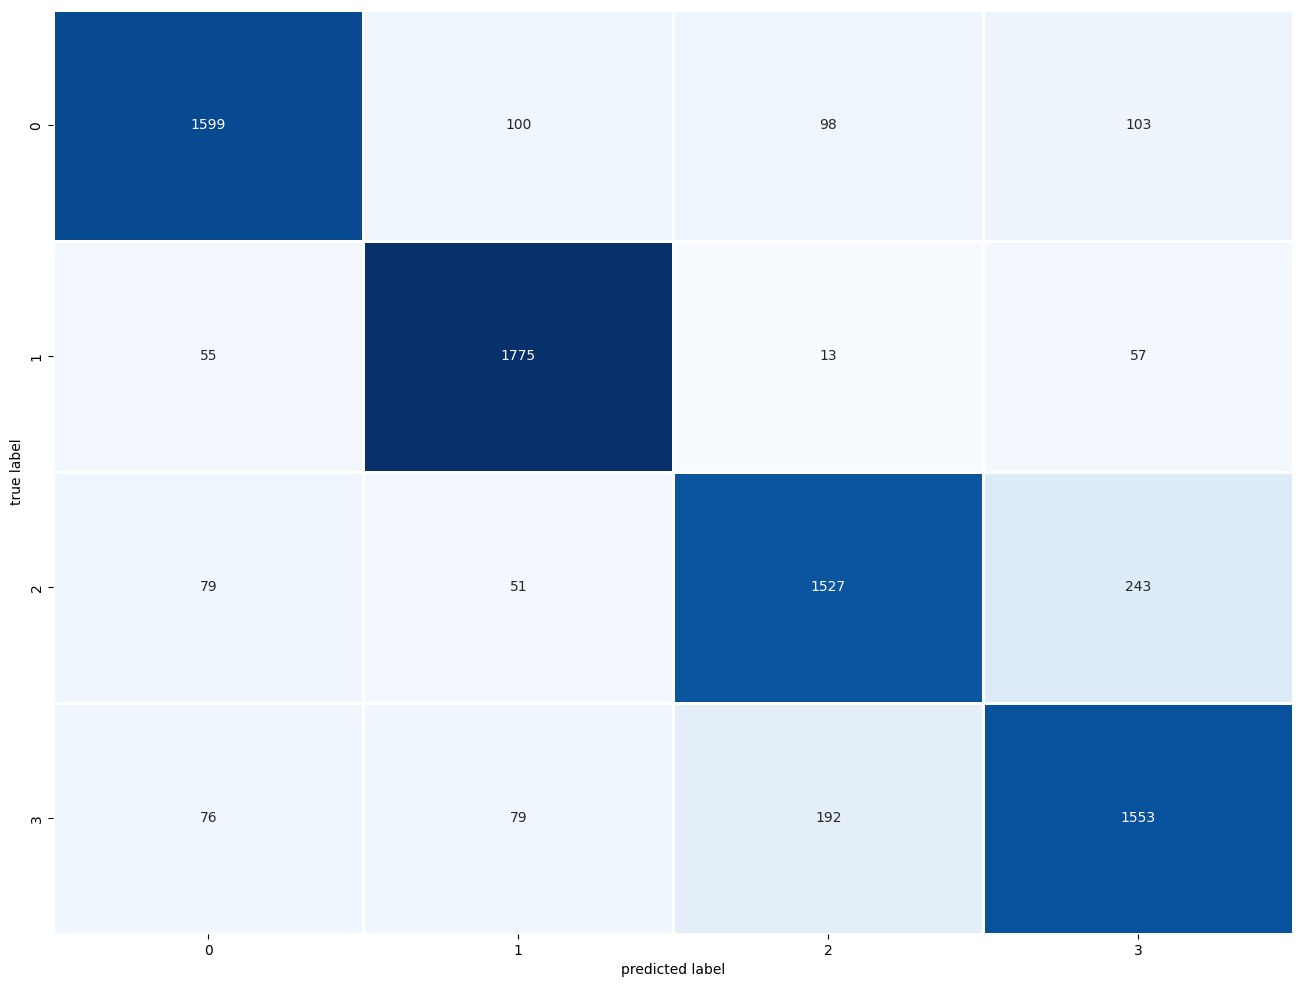

In [32]:
pred_cnn_2 = np.argmax(model_9.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_cnn_2)

plot_confusion_matrix(y_test, pred_cnn_2)

In [33]:
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
 # model 10

tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")

embedded = layers.Embedding(input_dim=max_tokens,
                            output_dim=256,
                            mask_zero=True)(inputs)

# First convolutional block
x = layers.Conv1D(64, 5, activation='relu', padding='same')(embedded)
x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Second convolutional block
x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Third convolutional block
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Global max pooling
x = layers.GlobalMaxPooling1D()(x)

# Dropout for regularization
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(4, activation="softmax")(x)


model_10= tf.keras.Model(inputs, outputs)
model_10.compile(optimizer="rmsprop",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

model_10.summary()

callbacks = [
    ModelCheckpoint("CNN.h5", save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=3)
]

history = model_10.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

# Load the best model from the checkpoint
model_10 = tf.keras.models.load_model("CNN.h5")

# Evaluate the model on the test set
test_accuracy = model_10.evaluate(int_test_ds)[1]
print(f"Test accuracy: {test_accuracy:.3f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          81984     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          20544     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         41088     
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
3563/3563 [==============================] - 635s 178ms/step - loss: 0.4392 - accuracy: 0.8506 - val_loss: 0.4115 - val_accuracy: 0.8582
Epoch 3/200
3563/3563 [==============================] - 634s 178ms/step - loss: 0.4258 - accuracy: 0.8568 - val_loss: 0.4444 - val_accuracy: 0.8555
Epoch 4/200
3563/3563 [==============================] - 632s 177ms/step - loss: 0.4335 - accuracy: 0.8583 - val_loss: 0.4825 - val_accuracy: 0.8515
Epoch 5/200
238/238 [==============================] - 10s 42ms/step - loss: 0.4248 - accuracy: 0.8579
Test accuracy: 0.858


238/238 [==============================] - 10s 42ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1900
           1       0.88      0.95      0.91      1900
           2       0.85      0.81      0.83      1900
           3       0.82      0.83      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8578947368421053
Root Mean Square Error: 0.6627296027157603


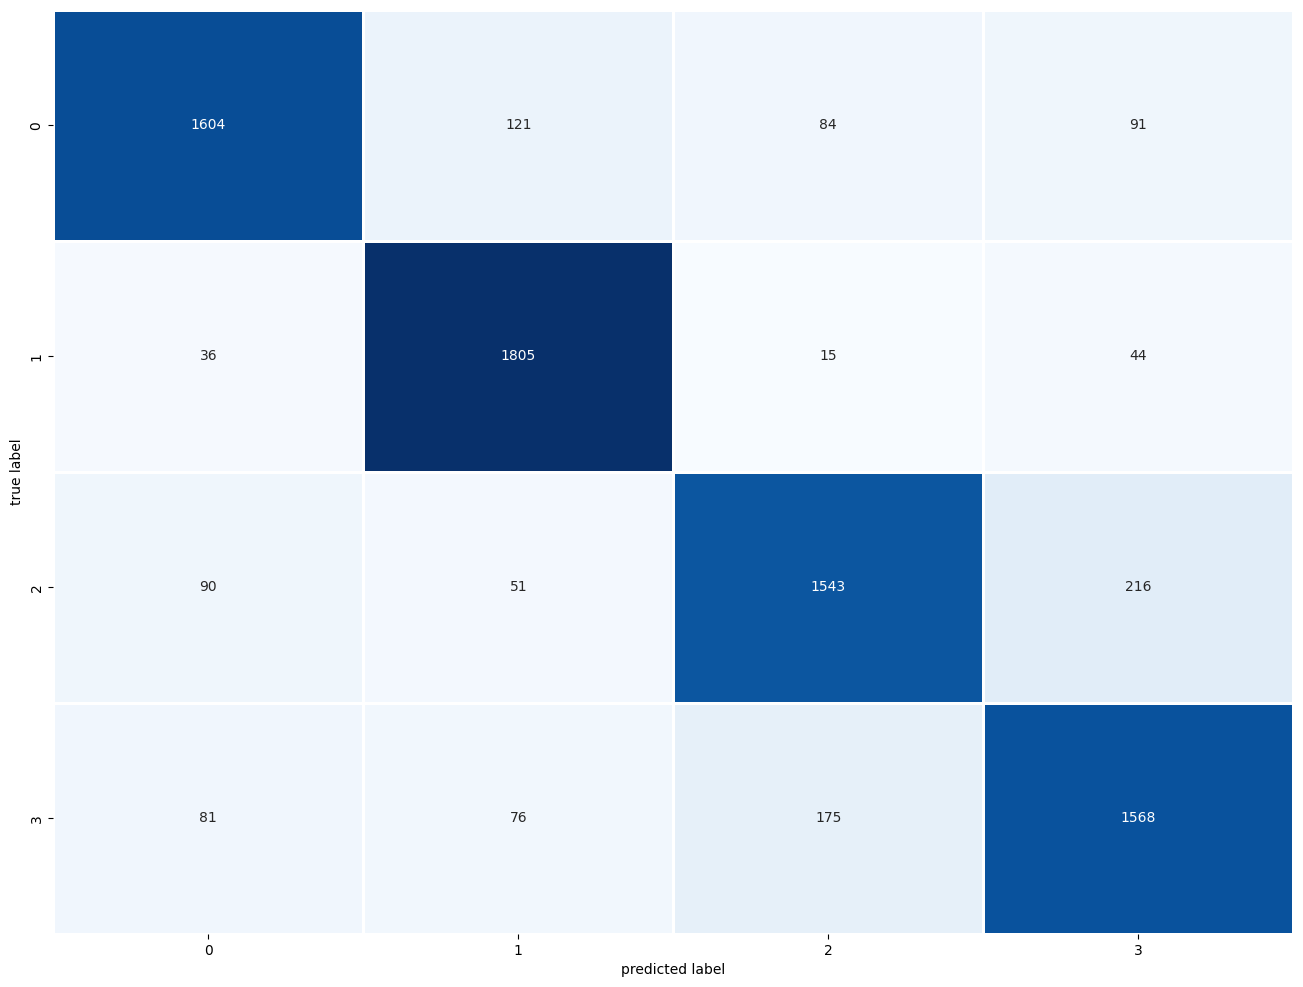

In [34]:
pred_cnn_3 = np.argmax(model_10.predict(int_test_ds), axis=-1)
print_validation_report(y_test, pred_cnn_3)

plot_confusion_matrix(y_test, pred_cnn_3)